In [540]:
import torch
import os
import numpy as np
import global_resources as gr
import random
import matplotlib.pyplot as plt


# import data

In [541]:
data_path = os.path.join(gr.default_dir, r'Data\breast-cancer-wisconsin.data')
df = gr.read_and_return_pd_df(data_path)
display(df.head())


The input file path is: 
d:\Important Files\Repositories\Quantitative-Investment-Algorithms\Data\breast-cancer-wisconsin.data
Reading the input file...


,id,clump_thickness,unif_cell_size,unif_cell_shape,marg_adhesion,single_spith_cell_size,bare_nuclei,bland_chrom,norm_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [542]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      699 non-null    int64 
 1   clump_thickness         699 non-null    int64 
 2   unif_cell_size          699 non-null    int64 
 3   unif_cell_shape         699 non-null    int64 
 4   marg_adhesion           699 non-null    int64 
 5   single_spith_cell_size  699 non-null    int64 
 6   bare_nuclei             699 non-null    object
 7   bland_chrom             699 non-null    int64 
 8   norm_nucleoli           699 non-null    int64 
 9   mitoses                 699 non-null    int64 
 10  class                   699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [543]:
df.replace('?', np.nan, inplace = True)
df.dropna(inplace = True)
# df.replace('?', -99999, inplace = True)
df.drop(['id'], axis = 1, inplace = True)
df["bare_nuclei"] = df["bare_nuclei"].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   clump_thickness         683 non-null    int64
 1   unif_cell_size          683 non-null    int64
 2   unif_cell_shape         683 non-null    int64
 3   marg_adhesion           683 non-null    int64
 4   single_spith_cell_size  683 non-null    int64
 5   bare_nuclei             683 non-null    int64
 6   bland_chrom             683 non-null    int64
 7   norm_nucleoli           683 non-null    int64
 8   mitoses                 683 non-null    int64
 9   class                   683 non-null    int64
dtypes: int64(10)
memory usage: 58.7 KB


# Implement K means cluster

In [544]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current device: {device.capitalize()}.")

Current device: Cuda.


Preprocess

In [545]:
X = np.array(df.drop(['class'], axis = 1)).astype('float64')
y = np.array(df['class']).astype('float64')
# Change label from 2, 4 to -1, 1, with 1 meaning that the label is malignant, -1 meaning that the label is benign.
y = np.where(y == 4, 1, np.where(y == 2, -1, y))

In [546]:
X_gpu = torch.tensor(X, device = device)
y_gpu = torch.tensor(y, device = device)
print(X_gpu.shape)
print(y_gpu.shape)

torch.Size([683, 9])
torch.Size([683])


# K means unsupervised

## Create centroids & Assign points to its closet centroids

In [547]:
RANDOM_SEED = random.randint(0, 2**32 - 1)
MAX_ITERATION = int(1e3)
TOLERANCE = 1e-6
N_RESTARTS = int(10)
def initiate_centroids(X = X_gpu, k = 3, random_seed = RANDOM_SEED):
    N = X.size(0)
    # GPU ways of doing it, but it randomly permute all data before sampling, and isn't the best practice:
    # generator = torch.Generator(device=X_gpu.device).manual_seed(RANDOM_SEED)
    # idx = torch.randperm(X_gpu.size(0), generator = generator, device = X_gpu.device)[:k]
    random.seed(random_seed)
    # draw k unique ints in [0..N-1]
    idx_cpu = random.sample(range(N), k)    
    # convert & move to GPU
    idx = torch.tensor(idx_cpu, device=X_gpu.device)
    centroids = X[idx]
    return centroids

# Usage for init_centroids
# Centroids = init_centroids(X_gpu)

In [548]:
# Set centroids example and explanation

# # Compute all N×k pairwise distances:
# # distances[i,j] = ||X_gpu[i] - centroids[j]||_2
# # Or you can use torch.norm, but I was told that torch.norm doesn't have a good precision as torch.cdist
# distances = torch.cdist(X_gpu, centroids)

# # Returns the index of the smallest within each first dimension
# labels = distances.argmin(dim = 1)    # shape: (N,)


## Re‑compute centroids as the mean of their assigned points

In [549]:
def optimize_centroids(X = X_gpu, centroids = None, max_iters = MAX_ITERATION, tol = TOLERANCE):
    labels = 0
    global RANDOM_SEED
    if centroids == None:
        centroids = initiate_centroids(X)
    for it in range(max_iters):
        labels = torch.cdist(X_gpu, centroids).argmin(dim = 1)
        new_centroids = torch.zeros_like(centroids)
        
        for j in range(centroids.size(0)):
            members = X_gpu[labels == j]
            if members.numel() == 0:
                RANDOM_SEED += 1
                centroids = initiate_centroids(X, k=centroids.size(0), random_seed = RANDOM_SEED)
            else:
                new_centroids[j] = members.mean(dim = 0)

        # If the new_centroids and old centroids are not more different than tol, it will break the loop
        if torch.allclose(new_centroids, centroids, atol = tol):
            # print(f"Converged at iter {it}")
            labels = torch.cdist(X_gpu, new_centroids).argmin(dim = 1)
            break
        if it == max_iters:
            print(f"Hit max_iters in optimize_centroids function!!!!")
        centroids = new_centroids
        
    return new_centroids, labels

# Usage for optimize_centroids
# Centroids, Labels = optimize_centroids(Centroids)

## Set up a function that calculates the total variation based on the centroids and X

In [550]:
def calculate_variation(X = X_gpu, centroids = None, labels = None):
    variation = 0.0
    if centroids == None or labels == None:
        centroids, labels = optimize_centroids(X)
    for j in range(centroids.size(0)):
        members = X_gpu[labels == j]
        diffs = members - centroids[j].unsqueeze(0)
        variation += torch.sum(diffs * diffs).item()
    return variation

# variation = calculate_variation() 

In [551]:
# Within cluster sum of squares
def WCSS_for_single_k(X = X_gpu, k = 3, n_restarts = N_RESTARTS, tol = TOLERANCE, max_iters = MAX_ITERATION):
    global RANDOM_SEED
    best_variation = float('inf')
    best_centroids = None
    best_labels = None

    for _ in range(n_restarts):
        RANDOM_SEED += 1
        Centroids = initiate_centroids(X, k, random_seed = RANDOM_SEED)
        
        Centroids, Labels = optimize_centroids(
            X = X,
            centroids = Centroids,
            max_iters = max_iters,
            tol = tol
        )

        var = calculate_variation(X, Centroids, Labels)

        # keep best
        if var < best_variation:
            best_variation = var
            best_centroids = Centroids.clone()
            best_labels = Labels.clone()

    return best_centroids, best_labels, best_variation


In [552]:
# best_C, best_L, best_var = WCSS_for_single_k(n_restarts = 100)
# print(f"Lowest variation={best_var:.4f}")
# print("Best centroids:\n", best_C)

In [ ]:
def elbow_plot(X = X_gpu, k = 10):
    ks = list(range(1, k + 1))
    variations = []

    for k in ks:
        _, _, var = WCSS_for_single_k(X, k)
        variations.append(var)
    
    if not variations:
        print("No valid results to plot.")
        return
    
    plt.figure(figsize=(8, 5))
    plt.scatter(ks[:len(variations)], variations, marker='o')
    plt.plot(ks[:len(variations)], variations, linestyle='-', alpha=0.7)
    plt.xticks(ks)
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Within-cluster variation")
    plt.title("Elbow Method for Optimal k")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    return variations

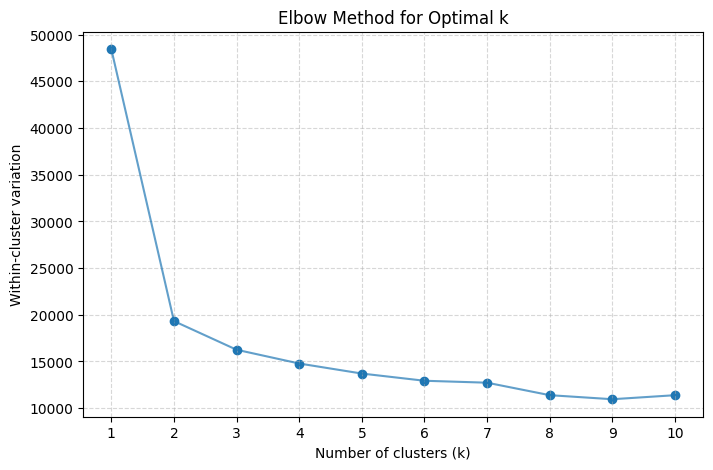

In [555]:
variations = elbow_plot(X = X_gpu, k = 10)